In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as stat
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (7,7)

In [2]:
df = pd.read_csv('top_500_routes.csv') # Dataframe with the top 500 routes all cleaned. 
df.drop('Unnamed: 0', axis=1, inplace=True) # Removing a weird CSV formatting thing.
# df = df[df['duration'] < 11000] # Test out with less outliers.

In [3]:
# Formatting the "conditions" column to only include 4 categories.

df['conditions'].replace('Partially cloudy', 'cloudy',inplace=True)
df['conditions'].replace('Overcast', 'cloudy',inplace=True)
df['conditions'].replace('Rain, Partially cloudy', 'Rain',inplace=True)
df['conditions'].replace('Rain, Overcast', 'Rain',inplace=True)
df['conditions'].replace('Snow, Partially cloudy', 'Snow', inplace=True)
df['conditions'].replace('Snow, Overcast', 'Snow', inplace=True)
df['conditions'].unique()

array(['cloudy', 'Clear', 'Rain', 'Snow'], dtype=object)

In [4]:
# Creating a new "hour" column.

df['starttime'] = df['starttime'].apply(lambda x: x[1:-1].split(','))
df['hour'] = df['starttime'].apply(lambda x: int(x[3].strip().replace('\'','')))
sns.histplot(df['hour'])

def time_day(x):
    ''' Reformats the starttime column to a categorical variable.
    '''
    if x >= 6 and x <= 10:
        return 'morning'
    elif x >= 11 and x <= 14:
        return 'lunch'
    elif x >= 17 and x <= 19:
        return 'evening'
    else:
        return 'night'
df['hour'] = df['hour'].apply(time_day)
print(df['hour'].value_counts())

night      148589
evening    127685
morning    106007
lunch       97809
Name: hour, dtype: int64


In [5]:
def change_temp(x):
    ''' Reformats the temperature column from integers to three different categorical variables.
    '''
    if x > 10:
        return 'warm'
    elif x >= 0 :
        return 'coldish'
    else:
        return 'rlly_cold'

print(df['temperature'].apply(change_temp).value_counts())
df['temperature'] = df['temperature'].apply(change_temp)

warm         360415
coldish      105094
rlly_cold     14581
Name: temperature, dtype: int64


In [6]:
def day_week(x):
    ''' Reformats "day_of_week" column to a binary category.
    '''
    if x != 'Saturday' and x != 'Sunday' and x != 'Friday':
        return 'working day'
    else:
        return 'weekend'

df['day_of_week'] = df['day_of_week'].apply(day_week)

In [7]:
reg_df = df[['duration', 'member', 'days_since_Jan1_2010', 'day_of_week', 'temperature', 'conditions', 'route', 'hour']]

# Creating Dummy Variables:
member = pd.get_dummies(reg_df['member'],drop_first=True, prefix='member')
conditions = pd.get_dummies(reg_df['conditions'], drop_first=True)
day_of_week = pd.get_dummies(reg_df['day_of_week'], drop_first=True)
temp = pd.get_dummies(reg_df['temperature'], drop_first=True)
time_of_day = pd.get_dummies(reg_df['hour'], drop_first=True)

reg_df = pd.concat((reg_df,member,conditions,day_of_week, time_of_day, temp), axis=1) # Add temp in after
reg_df.drop(['member', 'day_of_week', 'conditions','temperature', 'hour'], axis=1, inplace=True)

In [8]:
reg_df.head()

duration  days_since_Jan1_2010  \
0      1012                   262   
1      2690                   262   
2      1413                   262   
3       982                   262   
4       351                   262   

                                               route  member_True  Rain  Snow  \
0             M St & New Jersey Ave SE 4th & M St SW            1     0     0   
1        5th & K St NW 19th St & Pennsylvania Ave NW            1     0     0   
2       19th St & Pennsylvania Ave NW 15th & P St NW            1     0     0   
3  7th & T St NW Massachusetts Ave & Dupont Circl...            1     0     0   
4   16th & Harvard St NW Adams Mill & Columbia Rd NW            1     0     0   

   cloudy  working day  lunch  morning  night  rlly_cold  warm  
0       1            1      1        0      0          0     1  
1       1            1      1        0      0          0     1  
2       1            1      1        0      0          0     1  
3       1            1      1        0      0          0     1  
4       1            1      1        0      0          0     1

In [17]:
def permut_p_value(resid, days_since, num_perm=15000):
    """ Calculates the p-value by permuting the days since Jan 1st and calculating the correlation of the days since Jan1 with the OLS residuals.
    The null hypothesis is that there should be no correlation when permuting the days since and calculating the correlation with the residuals.
    """
    corr_avg = []
    for i in range(num_perm):
        perm = np.random.permutation(days_since)
        corr_avg.append(np.corrcoef(results.resid,perm)[1,0])
    corr_avg = np.array(corr_avg)
    p_val = sum(np.abs(corr_avg) > np.abs(np.corrcoef(results.resid,days_since)[1,0]))/num_perm
    return p_val

In [18]:
p_vals = []
model_resuls = []
number_observations = []
for route in tqdm(reg_df.route.unique()):
    # Getting the pandas dataframe into the right form for least squares.
    X = reg_df[reg_df['route'] == route]
    days_since = X['days_since_Jan1_2010']
    y = X['duration']
    X.drop(['route','days_since_Jan1_2010', 'duration'], axis=1,inplace=True)
    number_observations.append(len(X))

    # Running OLS
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    
    # Collecting the results
    p_val = permut_p_value(results.resid, days_since)
    p_vals.append(p_val)
    model_resuls.append(results)

100%|██████████| 500/500 [15:01<00:00,  1.80s/it]


smallest number of observations:  536
Average Number of Observations:  960.18


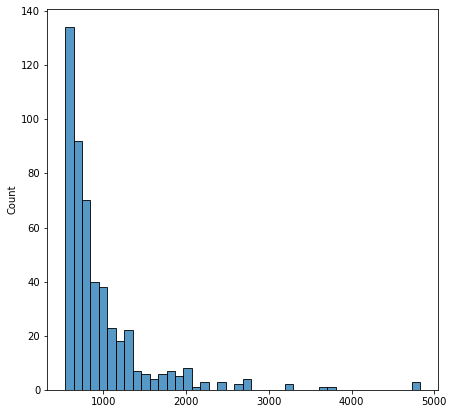

In [21]:
sns.histplot(number_observations)
print('smallest number of observations: ',min(number_observations))
print('Average Number of Observations: ' ,np.mean(number_observations))

In [22]:
p = sns.histplot(p_vals)
p.set_xlabel('P-values', fontsize=13)
p.set_ylabel('Count', fontsize=13)
p.set_title('Histogram of P-values', fontsize=15)

Text(0.5, 1.0, 'Histogram of P-values')

In [24]:
reject_lst, corrected_pvals_bon,z,k = stat.multitest.multipletests(p_vals, alpha = 0.05, method='bonferroni', returnsorted=False)
print('bonferroni ',sum(reject_lst))

reject_lst, corrected_pvals,z,k = stat.multitest.multipletests(p_vals, alpha = 0.05, method='fdr_tsbh', returnsorted=True)
print('two stage fdr correction (non-negative)',sum(reject_lst))

reject_lst, corrected_pvals,z,k = stat.multitest.multipletests(p_vals, alpha = 0.05, method='fdr_bh', returnsorted=False)
print('FDR BH',sum(reject_lst))

bonferroni  16
two stage fdr correction (non-negative) 76
FDR BH 65


In [25]:
np.where(corrected_pvals_bon <= 0.01)

(array([  3,   7,  72, 117, 126, 129, 142, 163, 268, 307, 427]),)

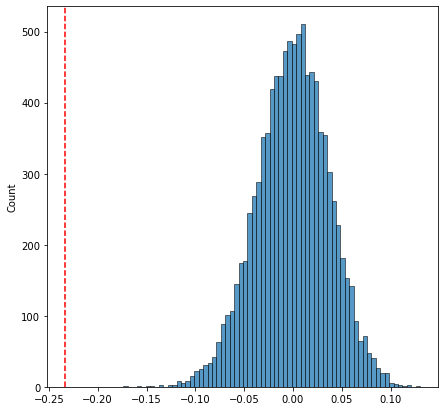

In [26]:
# This is for code testing purposes by looking at single routes only.

test_route = reg_df.route.unique()[268]
X = reg_df.drop(['duration'],axis=1)
X = X[X['route'] == test_route]
y = reg_df[reg_df['route'] == test_route]['duration']
days_since = X['days_since_Jan1_2010']
X.drop(['route','days_since_Jan1_2010'], axis=1,inplace=True)
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

correlation_permutation = []
real_corr = np.corrcoef(results.resid,days_since)[1,0]
for i in range(10000):
    perm = np.random.permutation(days_since)
    correlation_permutation.append(np.corrcoef(results.resid,perm)[1,0]) 

sns.histplot(correlation_permutation)
plt.axvline(real_corr,color='r', linestyle='--')

In [27]:
np.corrcoef(results.resid,days_since)[1,0]
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     14.05
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           5.67e-21
Time:                        11:16:14   Log-Likelihood:                -6352.2
No. Observations:                 718   AIC:                         1.272e+04
Df Residuals:                     708   BIC:                         1.277e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1435.1279    403.790      3.554      0.000     642.359    2227.897
member_True -1424.6985    134.832    -10.566      0.000   -1689.417   -1159.980
Rain          300.1873    349.693      0.858      0.391    -386.372     986.747
Snow          2.35e-13   2.59e-13      0.907      0.365   -2.73e-13    7.43e-13
cloudy        374.2145    342.157      1.094      0.274    -297.550    1045.979
working day    95.3954    133.931      0.712      0.477    -167.553     358.344
lunch         308.0613    221.856      1.389      0.165    -127.513     743.636
morning       356.0804    222.018      1.604      0.109     -79.813     791.974
night          50.6756    236.249      0.215      0.830    -413.157     514.508
rlly_cold    -130.6151    997.527     -0.131      0.896   -2089.081    1827.851
warm          157.7206    176.984      0.891      0.373    -189.755     505.196
==============================================================================
Omnibus:                      777.366   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43135.660
Skew:                           5.178   Prob(JB):                         0.00
Kurtosis:                      39.532   Cond. No.                     2.13e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.81e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
# This will track the real correlation values (not the permuted ones) for plotting and analysis.

lst_real_corr = []
for route in tqdm(reg_df.route.unique()):
    X = reg_df.drop(['duration'],axis=1)
    X = X[X['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    X.drop(['route','days_since_Jan1_2010'], axis=1,inplace=True)

    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    
    real_corr = np.corrcoef(results.resid,days_since)[1,0]
    lst_real_corr.append(real_corr)

100%|██████████| 500/500 [00:28<00:00, 17.48it/s]


In [30]:
p = sns.histplot(lst_real_corr)
p.set_xlabel('Correlation for each Route', fontsize=13)
p.set_ylabel('Count', fontsize=13)
p.set_title('Histogram of Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)

plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-', linewidth = 2.5, label='Mean Correlation')
plt.legend()

In [31]:
# Slightly Changing original function so it can plot residuals.
def permut_p_value(resid, days_since, num_perm=15000):
    perm_corr = []
    for i in range(num_perm):
        perm = np.random.permutation(days_since)
        perm_corr.append(np.corrcoef(results.resid,perm)[1,0])
    perm_corr = np.array(perm_corr)
    p_val = sum(np.abs(perm_corr) > np.abs(np.corrcoef(results.resid,days_since)[1,0]))/num_perm
    return p_val, perm_corr

In [32]:
significant_routes = [268, 362, 7]
lst_real_corr = []
perm_corr = []
lst_residuals = []
lst_days_since = []
p_vals = []
for route_index in significant_routes:
    route = reg_df.route.unique()[route_index]
    X = reg_df.drop(['duration'],axis=1)
    X = X[X['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    X.drop(['route','days_since_Jan1_2010'], axis=1,inplace=True)

    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    real_corr = np.corrcoef(results.resid,days_since)[1,0]
    
    lst_residuals.append(results.resid)
    lst_days_since.append(days_since)
    lst_real_corr.append(real_corr)

    p_val, corr_avg = permut_p_value(results.resid, days_since)
    p_vals.append(p_val)
    perm_corr.append(corr_avg)
    model_resuls.append(results)

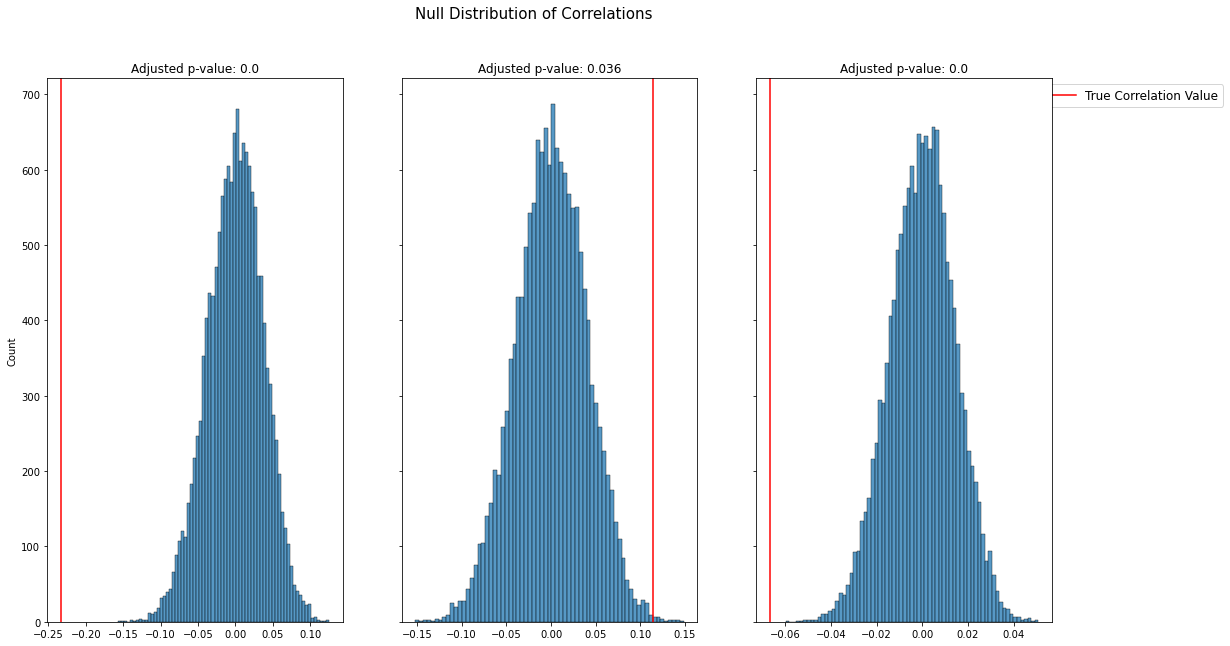

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)
sns.histplot(ax=axes[0], data=perm_corr[0], )
axes[0].axvline(lst_real_corr[0], color ='r')
axes[0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[268],3)}')

sns.histplot(ax=axes[1], data=perm_corr[1], )
axes[1].axvline(lst_real_corr[1], color ='r', label = 'True Correlation Value')
axes[1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[362],3)}')

sns.histplot(ax=axes[2], data=perm_corr[2], )
axes[2].axvline(lst_real_corr[2], color ='r')
axes[2].set_title(f'Adjusted p-value: {corrected_pvals[7]}')
plt.suptitle('Null Distribution of Correlations', fontsize=15)

axes[1].legend(loc="upper right", bbox_to_anchor=(2.8, 1), prop={'size': 12})

In [39]:
corrected_pvals[268]

0.0

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(23,10))
p = sns.residplot(ax=axes[0,0], x = lst_days_since[0], y= lst_residuals[0])
p.set_ylabel('Residuals', fontsize=14)
axes[0,0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[268],3)}')

sns.residplot(ax=axes[0,1], x = lst_days_since[1], y= lst_residuals[1])
axes[0,1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[362],3)}')

sns.residplot(ax=axes[0,2], x =lst_days_since[2], y=lst_residuals[2])
axes[0,2].set_title(f'Adjusted p-value: {corrected_pvals[7]}')


plt.yscale('log')
p = sns.residplot(ax=axes[1,0], x = lst_days_since[0], y= lst_residuals[0])
p.set_ylabel('Log (Residuals)', fontsize=14)
p.set_yscale('log')


p = sns.residplot(ax=axes[1,1], x = lst_days_since[1], y= lst_residuals[1])
p.set_yscale('log')

p = sns.residplot(ax=axes[1,2], x =lst_days_since[2], y=lst_residuals[2], )
plt.yscale('log')
plt.suptitle('Residual Plots from Three Significant Routes', fontsize=20)
plt.tight_layout()